# **Group Assignment** - Bike Sharing

- `instant`: record index
- `dteday` : date
- `season` : season 1:winter, 2:spring, 3:summer, 4:fall
- `yr` : year (0: 2011, 1:2012)
- `mnth` : month ( 1 to 12)
- `hr` : hour (0 to 23)
- `holiday` : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- `weekday` : day of the week
- `workingday` : if day is neither weekend nor holiday is 1, otherwise is 0.
+ `weathersit` : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- `temp` : Normalized temperature in Celsius. The values are divided to 41 (max)
- `atemp`: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- `hum`: Normalized humidity. The values are divided to 100 (max)
- `windspeed`: Normalized wind speed. The values are divided to 67 (max)
- `casual`: count of casual users
- `registered`: count of registered users
- `cnt`: count of total rental bikes including both casual and registered

### Load Functions and Libraries:

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import lightgbm as lgb
from pathlib import Path
from scipy.stats import zscore, uniform, randint
from plotly.subplots import make_subplots
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from joblib import dump

In [2]:
functions_path = Path("..") / "Functions"
sys.path.append(str(functions_path))

import eda
import preprocessing as prep
import modeling as mo

In [3]:
data, categorical_ordinal, categorical_columns, numerical_columns = eda.load_and_prepare_data(clean_print=True)

Dataset loaded successfully!
Shape of the dataset: (17379, 17)

Columns Defined:
Categorical Ordinal Columns: ['yr', 'mnth', 'season', 'weekday', 'hr']
Categorical Columns: ['holiday', 'workingday', 'weathersit']
Numerical Columns: ['temp', 'atemp', 'hum', 'windspeed']

Checking for Missing Values:
No missing values found.

Mean of All Columns (Numeric Only):
instant       8690.00
season           2.50
yr               0.50
mnth             6.54
hr              11.55
holiday          0.03
weekday          3.00
workingday       0.68
weathersit       1.43
temp             0.50
atemp            0.48
hum              0.63
windspeed        0.19
casual          35.68
registered     153.79
cnt            189.46
dtype: float64


### PART I -  Exploratory Data Analysis:

### Outlier Detection:

In this step, we used the Z-score method with a threshold of 3 to detect outliers. This means any value more than 3 standard deviations away from the mean (extremely unusual values) was identified as an outlier. These outliers were then removed to clean the dataset.

Boxplots were created for each feature to visualize the outliers before removal. After cleaning, the change in dataset size was reported, showing how many rows were removed due to outliers.

In [4]:
features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

df = eda.detect_and_remove_outliers_with_plots(data, features)

Outliers Detected (Z-Score):
casual        467
registered    371
cnt           244
temp            0
hum            22
windspeed     107
dtype: int64



Number of outliers removed: 964


In [5]:
print(f"Original data shape: {data.shape}")
print(f"Data shape after removing outliers: {df.shape}")

Original data shape: (17379, 17)
Data shape after removing outliers: (16415, 17)


In [6]:
eda.plot_casual_and_registered_users(df)

### Categorical Distributions:

Checking distributions helps us understand how the data is spread across different categories or values. It gives insights into whether the data is balanced, highlights patterns or trends, and helps identify potential issues like imbalances or anomalies that may need attention during analysis or modeling.

In [7]:
eda.plot_cat_dist(df, categorical_columns + categorical_ordinal)

### Numerical Distributions:

The distributions of the most numerical features have a roughly normal distribution, centered around a mean with symmetric spread. However, Windspeed appears to be skewed, with a majority of the values clustered at lower ranges, and Cnt (count) shows a highly skewed distribution, indicating that most data points have lower values with a long tail.

In [8]:
eda.plot_num_dist(df, numerical_columns + ['cnt'])

### Time - Based Analysis:

**Monthly Average Bike Usage (2011-2012):** 

Bike usage shows a seasonal trend, with low usage in winter and peaks in summer months like July and August, followed by a decline in fall and winter.

In [9]:
eda.plot_monthly_average_usage(df)

#### **Average Hourly Bike Usage (Weekdays vs. Weekends):** 

On weekdays, bike usage spikes at 8 AM and 5-6 PM during rush hours. On weekends, usage is steady throughout the day, peaking around 2-4 PM for leisure activities.

In [10]:
eda.plot_average_hourly_usage(df)

#### **Average Hourly Bike Usage: Weekdays vs. Weekends (Registered Users)**

Registered users show a sharp spike during weekday rush hours at 8 AM and 5-6 PM, with consistent low usage during weekends. This highlights their commuter-oriented usage pattern.

#### **Average Hourly Bike Usage: Weekdays vs. Weekends (Casual Users)**
Casual users have steady, low usage on weekdays but much higher usage on weekends, peaking around 2-4 PM, reflecting recreational or leisure-based usage trends.

In [11]:
eda.plot_hourly_usage(df, user_type='registered')
eda.plot_hourly_usage(df, user_type='casual')

### Impact of Weather on Bike Usage:

Bike usage is highest during clear or partly cloudy weather, with an average of 178 users, followed by misty or cloudy conditions at 158 users. Usage drops significantly in light snow or rain (104 users) and is lowest during heavy rain or snow (74 users), indicating weather has a strong impact on bike rental activity.

In [12]:
eda.plot_average_usage_by_weather(df)

### Impact Seasonality on Bike Usage

Bike usage varies significantly by season, with the highest usage in summer (205), followed by spring (178) and fall (176). Winter shows the lowest average usage at 107, likely due to colder weather and less favorable conditions for biking. This highlights a strong seasonal impact on bike rentals.

In [13]:
eda.plot_average_usage_by_season(df)

### Correlation Matrix

We noticed that temp - atemp and season - month were highly correlated, which could lead to multicollinearity in our model, especially in linear algorithms. Multicollinearity makes it difficult to determine the individual effect of each variable and can lead to unstable coefficients. To address this, we'll remove atemp and month since it was redundant and provided similar information.

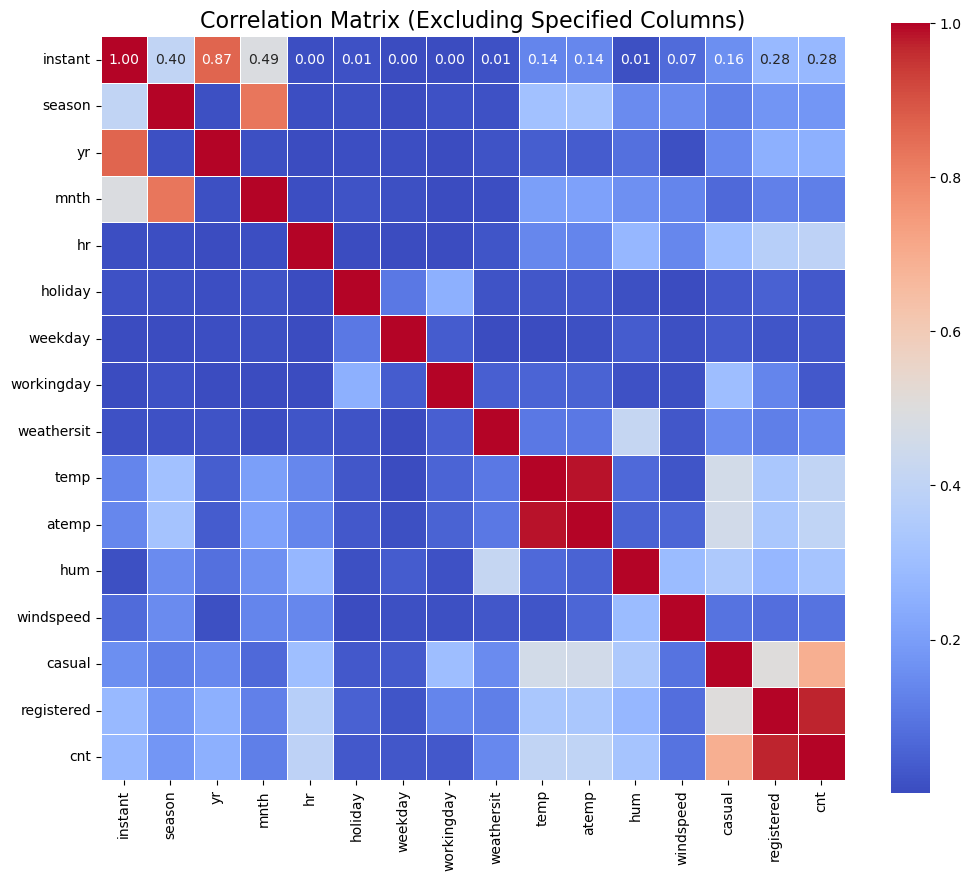

In [14]:
eda.plot_correlation_matrix(data, columns_to_exclude=['dteday'])

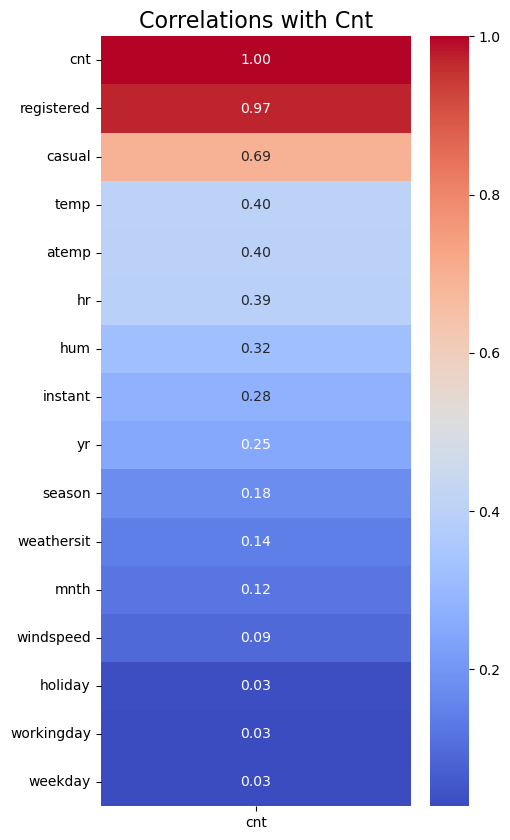

In [15]:
cnt_correlations = eda.plot_correlations(data, target_column='cnt', columns_to_exclude='dteday')

## PART II: Prediction Model


### Train - Test Split:

We split the data into train, validation, and test sets. The test set includes the last 2 months of data, while 20% of the remaining training data was used as the validation set for tuning the model. This setup ensures the model is tested on recent, unseen data for realistic performance evaluation.

In [16]:
X_train_final, X_val, X_test, y_train_final, y_val, y_test = prep.split_data(df)

print(X_train_final.shape, X_val.shape, X_test.shape)
print(y_train_final.shape, y_val.shape, y_test.shape)

Final Training set: (12008, 10), Validation set: (3002, 10), Testing set: (1405, 10)
Final Training set: (12008,), Validation set: (3002,), Testing set: (1405,)
(12008, 10) (3002, 10) (1405, 10)
(12008,) (3002,) (1405,)


### Feature Engineering:

### Categorize Daylight:

This function categorizes the hour of the day into four periods (Morning, Afternoon, Evening, Night) and adds a new column with these categories to the DataFrame. It helps capture time-of-day information for further analysis or model training.

In [17]:
X_train_final, X_val, X_test = prep.add_daylight_period_simple(X_train_final, X_val, X_test)

In [18]:
corr_hr = data['hr'].corr(data['cnt'])

print(f"Correlation to target - hour: {abs(corr_hr):.4f} \n"
      f"Correlation to target - daylight period: {abs(X_train_final['daylight_period'].corr(y_train_final)):.4f}")

Correlation to target - hour: 0.3941 
Correlation to target - daylight period: 0.2441


### Rush Hour:

We created a binary 'rush_hour' feature, marking peak commuting hours (7-9 AM, 5-7 PM) with 1, and all other hours with 0. This helps capture the impact of high demand times on bike usage.

In [19]:
prep.plot_hourly_bike_usage(data)

In [20]:
X_train_final = prep.add_rush_hour(X_train_final)
X_val = prep.add_rush_hour(X_val)
X_test = prep.add_rush_hour(X_test)

In [21]:
print(f"Correlation to target - hour: {X_train_final['hr'].corr(y_train_final):.4f} \n"
      f"Correlation to target - rush_hour: {X_train_final['rush_hour'].corr(y_train_final):.4f}")

Correlation to target - hour: 0.4132 
Correlation to target - rush_hour: 0.4618


### Add Cyclic Features:

Cyclic encoding creates two new features (sin and cos) for each cyclic column. This might help the model understand the inherent periodicity in the data and learn the relationships more effectively. For features like hr, weekday, season, and daylight period, it ensures the cyclic nature is properly represented in the feature space.

In [22]:
columns_to_check_train = ['daylight_period']
columns_to_check_full = ['season', 'mnth', 'weekday']

correlations_full = prep.compute_correlations(data, columns_to_check_full, target_column='cnt')

correlations_train = prep.compute_correlations(X_train_final.assign(cnt=y_train_final), columns_to_check_train, target_column='cnt')

for column, corr in correlations_full.items():
    print(f"Correlation between {column} and target: {abs(corr):.4f}")

for column, corr in correlations_train.items():
    print(f"Correlation between {column} and target: {abs(corr):.4f}")

Correlation between season and target: 0.1781
Correlation between mnth and target: 0.1206
Correlation between weekday and target: 0.0269
Correlation between daylight_period and target: 0.2441


### Hour:

In [23]:
X_train_final = prep.add_cyclic_features(X_train_final, 'hr', 23)
X_val = prep.add_cyclic_features(X_val, 'hr', 23)
X_test = prep.add_cyclic_features(X_test, 'hr', 23)

In [24]:
corr_hr_sin = X_train_final['hr_sin'].corr(y_train_final)
corr_hr_cos = X_train_final['hr_cos'].corr(y_train_final)

print(f"Correlation to target - hour: {abs(corr_hr):.4f} \n"
      f"Correlation to target - hr_sin: {abs(corr_hr_sin):.4f} \n"
      f"Correlation to target - hr_cos: {abs(corr_hr_cos):.4f}")

Correlation to target - hour: 0.3941 
Correlation to target - hr_sin: 0.4537 
Correlation to target - hr_cos: 0.3444


### Season:

In [25]:
X_train_final = prep.add_cyclic_features(X_train_final, 'season', 4)
X_val = prep.add_cyclic_features(X_val, 'season', 4)
X_test = prep.add_cyclic_features(X_test, 'season', 4)

In [26]:
corr_season = data['season'].corr(data['cnt'])
corr_season_sin = X_train_final['season_sin'].corr(y_train_final)
corr_season_cos = X_train_final['season_cos'].corr(y_train_final)

print(f"Correlation to target - season: {abs(corr_season):.4f} \n"
      f"Correlation to target - season_sin: {abs(corr_season_sin):.4f} \n"
      f"Correlation to target - season_cos: {abs(corr_season_cos):.4f}")

Correlation to target - season: 0.1781 
Correlation to target - season_sin: 0.1998 
Correlation to target - season_cos: 0.0815


### Daylight Period:

In [27]:
X_train_final = prep.add_cyclic_features(X_train_final, 'daylight_period', 4)
X_val = prep.add_cyclic_features(X_val, 'daylight_period', 4)
X_test = prep.add_cyclic_features(X_test, 'daylight_period', 4)

### Weekday:

In [28]:
X_train_final = prep.add_cyclic_features(X_train_final, 'weekday', 6)
X_val = prep.add_cyclic_features(X_val, 'weekday', 6)
X_test = prep.add_cyclic_features(X_test, 'weekday', 6)

X_train_final.head()

,yr,holiday,workingday,weathersit,temp,hum,windspeed,rush_hour,hr_sin,hr_cos,season_sin,season_cos,daylight_period_sin,daylight_period_cos,weekday_sin,weekday_cos
0,0,0,0,1,0.24,0.81,0.0,0,0.000000,1.000000,1.0,6.123234e-17,-2.449294e-16,1.0,-2.449294e-16,1.0
1,0,0,0,1,0.22,0.80,0.0,0,0.269797,0.962917,1.0,6.123234e-17,-2.449294e-16,1.0,-2.449294e-16,1.0
2,0,0,0,1,0.22,0.80,0.0,0,0.519584,0.854419,1.0,6.123234e-17,-2.449294e-16,1.0,-2.449294e-16,1.0
3,0,0,0,1,0.24,0.75,0.0,0,0.730836,0.682553,1.0,6.123234e-17,-2.449294e-16,1.0,-2.449294e-16,1.0
4,0,0,0,1,0.24,0.75,0.0,0,0.887885,0.460065,1.0,6.123234e-17,-2.449294e-16,1.0,-2.449294e-16,1.0


In [29]:
corr_weekday = data['weekday'].corr(y_train_final)
corr_weekday_sin = X_train_final['weekday_sin'].corr(y_train_final)
corr_weekday_cos = X_train_final['weekday_cos'].corr(y_train_final)

print(f"Correlation to target - weekday: {abs(corr_weekday):.4f} \n"
      f"Correlation to target - weekday_sin: {abs(corr_weekday_sin):.4f} \n"
      f"Correlation to target - weekday_cos: {abs(corr_weekday_cos):.4f}")

Correlation to target - weekday: 0.0184 
Correlation to target - weekday_sin: 0.0186 
Correlation to target - weekday_cos: 0.0438


### Temperate - Humidity:

Temperature and humidity are related—higher temperatures can lead to increased humidity because warmer air can hold more moisture. By adding them together, the interaction feature captures the combined effect of these variables, which is useful in understanding their joint influence on the target outcome, such as bike usage. 

This combined impact can help reflect real-world conditions more accurately, as both temperature and humidity can significantly affect comfort levels and people's willingness to engage in outdoor activities.

In [30]:
X_train_final = prep.temp_hum(X_train_final)
X_val = prep.temp_hum(X_val)
X_test = prep.temp_hum(X_test)

In [31]:
corr_temp = abs(X_train_final['temp'].corr(y_train_final))
corr_hum = abs(X_train_final['hum'].corr(y_train_final))
corr_temp_hum = abs(X_train_final['temp_hum'].corr(y_train_final))

print(f"Correlation to target - temp: {corr_temp:.4f} \n"
      f"Correlation to target - humidity: {corr_hum:.4f} \n"
      f"Correlation to target - temp_hum: {corr_temp_hum:.4f}")

Correlation to target - temp: 0.3880 
Correlation to target - humidity: 0.2995 
Correlation to target - temp_hum: 0.0521


### Temperature - Windspeed:

Temperature and windspeed are factors that often work together to influence perceived comfort. On hot days, a higher windspeed can help reduce discomfort by providing a cooling effect, while on cooler days, wind can make temperatures feel even colder. 

By combining these two features, the interaction captures their joint impact, which can help in understanding how they together influence behaviors like bike usage.

In [32]:
X_train_final = prep.temp_windspeed(X_train_final)
X_val = prep.temp_windspeed(X_val)
X_test = prep.temp_windspeed(X_test)

In [33]:
corr_wind = abs(X_train_final['windspeed'].corr(y_train_final))
corr_temp_windspeed = abs(X_train_final['temp_windspeed'].corr(y_train_final))

print(f"Correlation to target - temp: {corr_temp:.4f} \n"
      f"Correlation to target - windspeed: {corr_hum:.4f} \n"
      f"Correlation to target - temp_windspeed: {corr_temp_windspeed:.4f}")

Correlation to target - temp: 0.3880 
Correlation to target - windspeed: 0.2995 
Correlation to target - temp_windspeed: 0.3873


### Windspeed - Humidity:

Windspeed and humidity interact in ways that can greatly influence how weather conditions are perceived. Higher humidity can make the air feel heavy and uncomfortable, especially in low-wind conditions. However, stronger winds can help disperse moisture in the air, making a humid environment feel more bearable. 

In [34]:
X_train_final = prep.hum_windspeed(X_train_final)
X_val = prep.hum_windspeed(X_val)
X_test = prep.hum_windspeed(X_test)

X_train_final.head()

,yr,holiday,workingday,weathersit,temp,hum,windspeed,rush_hour,hr_sin,hr_cos,season_sin,season_cos,daylight_period_sin,daylight_period_cos,weekday_sin,weekday_cos,temp_hum,temp_windspeed,hum_windspeed
0,0,0,0,1,0.24,0.81,0.0,0,0.000000,1.000000,1.0,6.123234e-17,-2.449294e-16,1.0,-2.449294e-16,1.0,1.05,0.24,0.81
1,0,0,0,1,0.22,0.80,0.0,0,0.269797,0.962917,1.0,6.123234e-17,-2.449294e-16,1.0,-2.449294e-16,1.0,1.02,0.22,0.80
2,0,0,0,1,0.22,0.80,0.0,0,0.519584,0.854419,1.0,6.123234e-17,-2.449294e-16,1.0,-2.449294e-16,1.0,1.02,0.22,0.80
3,0,0,0,1,0.24,0.75,0.0,0,0.730836,0.682553,1.0,6.123234e-17,-2.449294e-16,1.0,-2.449294e-16,1.0,0.99,0.24,0.75
4,0,0,0,1,0.24,0.75,0.0,0,0.887885,0.460065,1.0,6.123234e-17,-2.449294e-16,1.0,-2.449294e-16,1.0,0.99,0.24,0.75


In [35]:
corr_hum_wind = abs(X_train_final['temp_hum'].corr(y_train_final))

print(f"Correlation to target - windspeed: {corr_temp:.4f} \n"
      f"Correlation to target - humidity: {corr_hum:.4f} \n"
      f"Correlation to target - hum_wind: {corr_hum_wind:.4f}")

Correlation to target - windspeed: 0.3880 
Correlation to target - humidity: 0.2995 
Correlation to target - hum_wind: 0.0521


### Skewness Analysis:

Skewness is a measure that tells us how much a distribution deviates from being symmetric.

- If a column is highly skewed (usually with a skewness greater than 1), it means there are extreme values or a long tail on one side of the distribution.
- Highly skewed features can make it difficult for machine learning models to learn effectively, as these extreme values can dominate.
- In this step, we calculate the skewness of each numerical column and identify those that need transformation to reduce skewness.
- We usually apply a log transformation to reduce skewness, making the data closer to a normal distribution and improving model performance.
  
By analyzing the skewness and transforming highly skewed columns, we ensure that the features are easier for the model to interpret, leading to better generalization.

Column: holiday, Skewness: 5.6385
Column: weathersit, Skewness: 1.2280
Column: windspeed, Skewness: 0.5749
Column: casual, Skewness: 2.4992
Column: registered, Skewness: 1.5579
Column: cnt, Skewness: 1.2774


(None, <Axes: >)

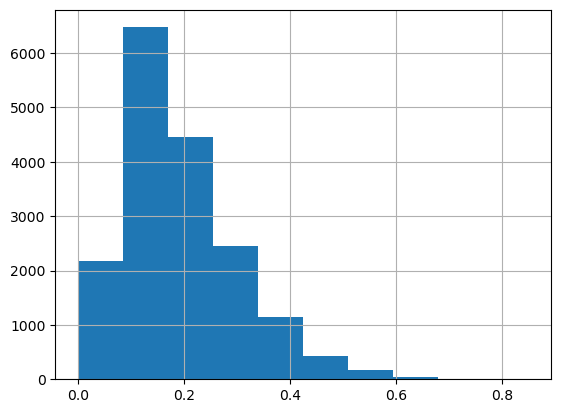

In [36]:
prep.calculate_skewness(data), data['windspeed'].hist()

In [37]:
prep.apply_transformation_and_check_correlation(data, 'windspeed', 'cnt')

Correlations for windspeed:
Original Correlation: 0.0932
Sqrt Transformation Correlation: 0.0960
Log Transformation Correlation: 0.0970


Even though they correlations are similar we decided to take the log because it is a little more correlated.

In [38]:
X_train_final, X_val, X_test = prep.apply_log([X_train_final, X_val, X_test], 'windspeed')

X_train_final.head()

,yr,holiday,workingday,weathersit,temp,hum,rush_hour,hr_sin,hr_cos,season_sin,season_cos,daylight_period_sin,daylight_period_cos,weekday_sin,weekday_cos,temp_hum,temp_windspeed,hum_windspeed,windspeed_log
0,0,0,0,1,0.24,0.81,0,0.000000,1.000000,1.0,6.123234e-17,-2.449294e-16,1.0,-2.449294e-16,1.0,1.05,0.24,0.81,0.0
1,0,0,0,1,0.22,0.80,0,0.269797,0.962917,1.0,6.123234e-17,-2.449294e-16,1.0,-2.449294e-16,1.0,1.02,0.22,0.80,0.0
2,0,0,0,1,0.22,0.80,0,0.519584,0.854419,1.0,6.123234e-17,-2.449294e-16,1.0,-2.449294e-16,1.0,1.02,0.22,0.80,0.0
3,0,0,0,1,0.24,0.75,0,0.730836,0.682553,1.0,6.123234e-17,-2.449294e-16,1.0,-2.449294e-16,1.0,0.99,0.24,0.75,0.0
4,0,0,0,1,0.24,0.75,0,0.887885,0.460065,1.0,6.123234e-17,-2.449294e-16,1.0,-2.449294e-16,1.0,0.99,0.24,0.75,0.0


### One Hot Encoding:

In [39]:
X_train_final, X_val, X_test = prep.one_hot_encode_column(X_train_final, X_val, X_test, 'weathersit')

In [40]:
print(f"Shape of X_train_final: {X_train_final.shape}")
print(f"Shape of y_train_final: {y_train_final.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train_final: (12008, 21)
Shape of y_train_final: (12008,)
Shape of X_val: (3002, 21)
Shape of y_val: (3002,)
Shape of X_test: (1405, 21)
Shape of y_test: (1405,)


## Modeling:

### 1) Modeling with Default Parameters over Validation:

#### Trying out different tree models:

In [41]:
rf = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
lgb_model = lgb.LGBMRegressor(random_state=42)

rf_metrics = mo.train_evaluate_model(rf, "Random Forest", X_train_final, y_train_final, X_val, y_val)

xgb_metrics = mo.train_evaluate_model(xgb, "XGBoost", X_train_final, y_train_final, X_val, y_val)

lgb_metrics = mo.train_evaluate_model(lgb_model, "LightGBM", X_train_final, y_train_final, X_val, y_val)

Training and evaluating: Random Forest
Training MAE: 9.20
Training MAPE: 0.1395
Validation MAE: 42.16
Validation MAPE: 0.2598

--------------------------------------------------

Training and evaluating: XGBoost
Training MAE: 14.46
Training MAPE: 0.3275
Validation MAE: 39.39
Validation MAPE: 0.3506

--------------------------------------------------

Training and evaluating: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 12008, number of used features: 20
[LightGBM] [Info] Start training from score 150.948951
Training MAE: 19.93
Training MAPE: 0.4086
Validation MAE: 38.64
Validation MAPE: 0.3330

--------------------------------------------------



### "Linear" Model - Support Vector Machine:

We chose a linear Support Vector Machine (SVM) because it’s more robust than Linear Regression in handling variability within the data. SVM focuses on maximizing the margin between data points, making it less sensitive to small fluctuations or noise

In [42]:
svm_metrics = mo.train_evaluate_svm(
    X_train=X_train_final,
    y_train=y_train_final,
    X_val=X_val,
    y_val=y_val,
    kernel='rbf',
    C=1.0,         
    epsilon=0.1    
)

print("SVM Metrics:", svm_metrics)

Training and evaluating: Support Vector Machine (SVM)
Training MAE: 54.24
Training MAPE: 1.2737
Validation MAE: 91.62
Validation MAPE: 1.2809

--------------------------------------------------

SVM Metrics: {'mae_train': 54.23889477077657, 'mape_train': 1.2737393850113012, 'mae_val': 91.62141212809726, 'mape_val': 1.2808611477988519}


### 2) Predicting over Test to see if there's any clear winner:

Since SVM gave us the worst result we decided to just keep going with the tree based models. The point was to check how the models were handling unseen data.

In [43]:
X_train_val = pd.concat([X_train_final, X_val])
y_train_val = pd.concat([y_train_final, y_val])

print(f"Shape of X_train_val: {X_train_val.shape}")
print(f"Shape of y_train_val: {y_train_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train_val: (15010, 21)
Shape of y_train_val: (15010,)
Shape of X_test: (1405, 21)
Shape of y_test: (1405,)


In [44]:
rf_metrics_test = mo.train_evaluate_model(rf, "Random Forest", X_train_val, y_train_val, X_test, y_test)

xgb_metrics_test = mo.train_evaluate_model(xgb, "XGBoost", X_train_val, y_train_val, X_test, y_test)

lgb_metrics_test = mo.train_evaluate_model(lgb_model, "LightGBM", X_train_val, y_train_val, X_test, y_test)

Training and evaluating: Random Forest
Training MAE: 9.65
Training MAPE: 0.1303
Validation MAE: 45.98
Validation MAPE: 0.5322

--------------------------------------------------

Training and evaluating: XGBoost
Training MAE: 16.22
Training MAPE: 0.3118
Validation MAE: 40.27
Validation MAPE: 0.7235

--------------------------------------------------

Training and evaluating: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 15010, number of used features: 20
[LightGBM] [Info] Start training from score 165.597868
Training MAE: 21.94
Training MAPE: 0.4170
Validation MAE: 39.64
Validation MAPE: 0.5972

--------------------------------------------------



The test results worsened because y_train is highly skewed, causing the model to focus on predicting the more frequent lower values while neglecting the higher values. This lack of balance makes it harder for the model to generalize to the test set, especially when higher target values are present.

To address this, we can apply a transformation, like a logarithmic scale, to reduce the skewness in y_train. This makes the target distribution more balanced, allowing the model to learn patterns across the full range of values. After training, we reverse the transformation on predictions to get the original scale. This should help improve generalization and test performance.

<Axes: >

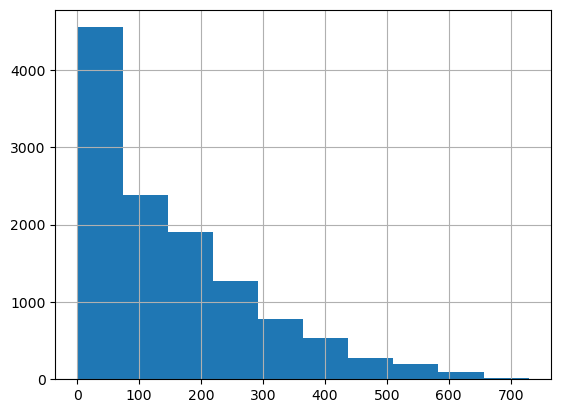

In [45]:
y_train_final.hist()

### 3) Applying logarithm to y_train

The log transformation was applied to address the skewness of the target variable, as heavily skewed data can make tree-based models overfit or struggle with predictions. By stabilizing variance and reducing outliers' influence, it aimed to make the data easier for the model to handle and improve generalization.

In [46]:
rf_metrics_log = mo.train_evaluate_model_with_log(rf, "Random Forest", X_train_final, y_train_final, X_val, y_val)

xgb_metrics_log = mo.train_evaluate_model_with_log(xgb, "XGBoost", X_train_final, y_train_final, X_val, y_val)

lgb_metrics_log = mo.train_evaluate_model_with_log(lgb_model, "LightGBM", X_train_final, y_train_final, X_val, y_val)

Training and evaluating with log transformation: Random Forest
Training MAE: 9.41
Training MAPE: 0.1062
Validation MAE: 47.59
Validation MAPE: 0.2659

--------------------------------------------------

Training and evaluating with log transformation: XGBoost
Training MAE: 15.73
Training MAPE: 0.1670
Validation MAE: 38.96
Validation MAPE: 0.2249

--------------------------------------------------

Training and evaluating with log transformation: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 12008, number of used features: 20
[LightGBM] [Info] Start training from score 4.377096
Training MAE: 20.82
Training MAPE: 0.2343
Validation MAE: 39.68
Validation MAPE: 0.2183

-----------------------------------------------

Testing showed that XGB performed better with the log transformation, with lower validation errors and a narrower training-validation gap. Since the results were more consistent and simpler to interpret without it, we decided to proceed without the transformation.

### 4) Feature Importance

We used the model's feature importance scores to rank features by relevance, calculated their cumulative importance, and selected only those contributing up to 99.1% of the total. This filtered the datasets to include only the most impactful features, streamlining our analysis.

### Random Forest:

Selected Features (16): ['hr_sin', 'daylight_period_cos', 'temp', 'workingday', 'hr_cos', 'weekday_cos', 'hum_windspeed', 'yr', 'weathersit_3', 'temp_windspeed', 'hum', 'season_cos', 'temp_hum', 'season_sin', 'rush_hour', 'windspeed_log']
Filtered Train Shape: (12008, 16)
Filtered Validation Shape: (3002, 16)
Filtered Test Shape: (1405, 16)

Unfiltered Train Shape: (12008, 21)
Unfiltered Validation Shape: (3002, 21)
Unfiltered Test Shape: (1405, 21)



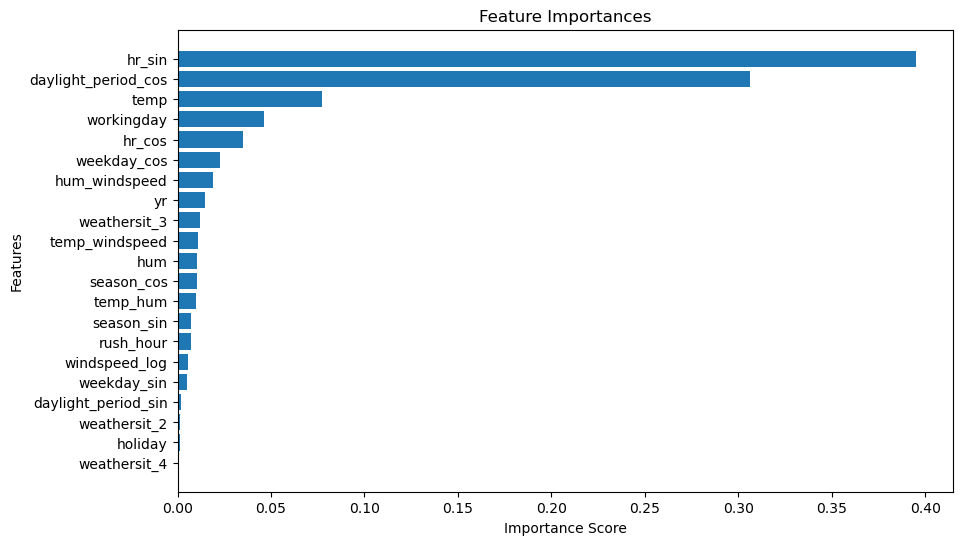

In [47]:
X_train_rf, X_val_rf, X_test_rf, selected_features_rf = mo.select_features_by_importance(
    model=rf,  
    X_train=X_train_final,
    X_val=X_val,
    X_test=X_test,
    threshold=0.991  
)

In [48]:
metrics_full_features = mo.train_evaluate_model(
    model=rf, 
    model_name="Random Forest (Full Features)", 
    X_train=X_train_final, 
    y_train=y_train_final, 
    X_val=X_val, 
    y_val=y_val
)

metrics_reduced_features = mo.train_evaluate_model(
    model=rf, 
    model_name="Random Forest (Reduced Features)", 
    X_train=X_train_rf, 
    y_train=y_train_final, 
    X_val=X_val_rf, 
    y_val=y_val
)

Training and evaluating: Random Forest (Full Features)
Training MAE: 9.20
Training MAPE: 0.1395
Validation MAE: 42.16
Validation MAPE: 0.2598

--------------------------------------------------

Training and evaluating: Random Forest (Reduced Features)
Training MAE: 9.47
Training MAPE: 0.1430
Validation MAE: 43.80
Validation MAPE: 0.2729

--------------------------------------------------



### XGBoost:

Selected Features (16): ['daylight_period_cos', 'hr_sin', 'workingday', 'rush_hour', 'weathersit_3', 'temp', 'yr', 'season_sin', 'weekday_cos', 'hr_cos', 'daylight_period_sin', 'weekday_sin', 'hum_windspeed', 'hum', 'holiday', 'season_cos']
Filtered Train Shape: (12008, 16)
Filtered Validation Shape: (3002, 16)
Filtered Test Shape: (1405, 16)

Unfiltered Train Shape: (12008, 21)
Unfiltered Validation Shape: (3002, 21)
Unfiltered Test Shape: (1405, 21)



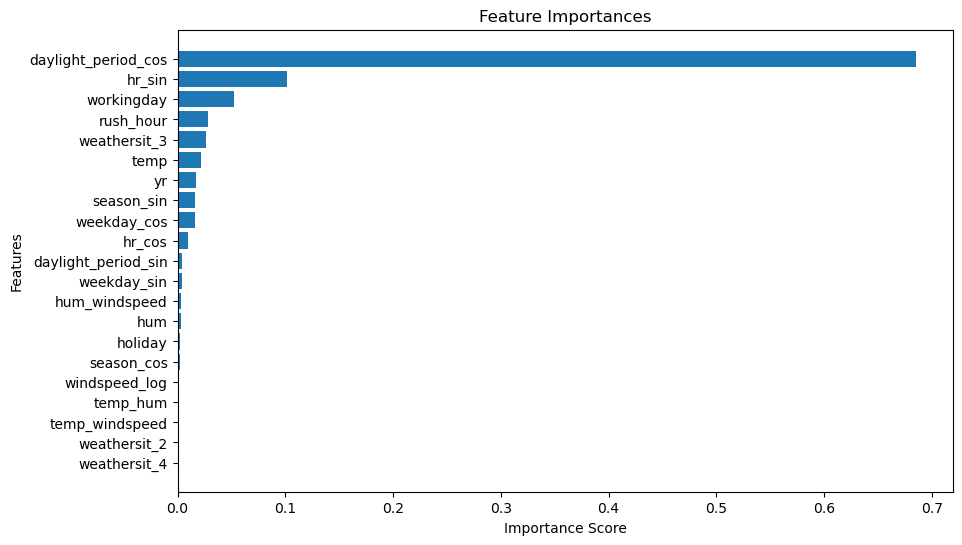

In [49]:
X_train_xgb, X_val_xgb, X_test_xgb, selected_features_xgb = mo.select_features_by_importance(
    model=xgb,  
    X_train=X_train_final,
    X_val=X_val,
    X_test=X_test,
    threshold=0.995  
)

In [50]:
metrics_full_features = mo.train_evaluate_model_with_log(
    model=xgb, 
    model_name="XGBoost (Full Features)", 
    X_train=X_train_final, 
    y_train=y_train_final, 
    X_val=X_val, 
    y_val=y_val
)

metrics_reduced_features = mo.train_evaluate_model_with_log(
    model=xgb, 
    model_name="XGBoost (Reduced Features)", 
    X_train=X_train_xgb, 
    y_train=y_train_final, 
    X_val=X_val_xgb, 
    y_val=y_val
)

Training and evaluating with log transformation: XGBoost (Full Features)
Training MAE: 15.73
Training MAPE: 0.1670
Validation MAE: 38.96
Validation MAPE: 0.2249

--------------------------------------------------

Training and evaluating with log transformation: XGBoost (Reduced Features)
Training MAE: 15.86
Training MAPE: 0.1715
Validation MAE: 36.17
Validation MAPE: 0.2152

--------------------------------------------------



### LightGBM:

LightGBM uses gradient-based one-side sampling (GOSS) and exclusive feature bundling (EFB), which inherently prioritize important features during training. This makes it naturally robust to irrelevant or low-importance features.

### Hyperparameter Tunning:

We'll be focusing on XGBoost for tuning because it has demonstrated the best validation performance after feature selection, achieving the lowest validation MAE compared to LightGBM and Random Forest. This indicates that XGBoost is particularly responsive to feature selection, showing improved generalization to the validation set. 

Additionally, its strong performance with reduced features highlights its potential for further optimization through hyperparameter tuning.

In [51]:
param_grid = {
    'n_estimators': randint(50, 1000),  
    'learning_rate': uniform(0.01, 0.29),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'num_parallel_tree': randint(10, 21),
    'gamma': uniform(0, 0.5),
    'reg_lambda': uniform(1, 9),
    'reg_alpha': uniform(0, 1),
    'min_child_weight': randint(1, 21)
}

In [52]:
best_params, best_score_log, best_score = mo.perform_randomized_search(
    X_train=X_train_xgb,
    y_train=y_train_final,
    param_grid=param_grid,
    n_iter=100,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END colsample_bytree=0.8123620356542087, gamma=0.4753571532049581, learning_rate=0.22227824312530747, max_depth=7, min_child_weight=7, n_estimators=171, num_parallel_tree=12, reg_alpha=0.09997491581800289, reg_lambda=5.133240027692804, subsample=0.8001125833417065; total time=   0.8s
[CV] END colsample_bytree=0.8123620356542087, gamma=0.4753571532049581, learning_rate=0.22227824312530747, max_depth=7, min_child_weight=7, n_estimators=171, num_parallel_tree=12, reg_alpha=0.09997491581800289, reg_lambda=5.133240027692804, subsample=0.8001125833417065; total time=   0.9s
[CV] END colsample_bytree=0.8123620356542087, gamma=0.4753571532049581, learning_rate=0.22227824312530747, max_depth=7, min_child_weight=7, n_estimators=171, num_parallel_tree=12, reg_alpha=0.09997491581800289, reg_lambda=5.133240027692804, subsample=0.8001125833417065; total time=   0.9s
[CV] END colsample_bytree=0.7723076398078035, gamma=0.3416317594127

/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



[CV] END colsample_bytree=0.9184649045835578, gamma=0.1838915663596266, learning_rate=0.19336869087213804, max_depth=8, min_child_weight=11, n_estimators=560, num_parallel_tree=10, reg_alpha=0.15071754396542947, reg_lambda=5.573788990666468, subsample=0.9087438420372645; total time=   2.1s
[CV] END colsample_bytree=0.7686394496474867, gamma=0.038489954914396496, learning_rate=0.09402792134499272, max_depth=8, min_child_weight=2, n_estimators=731, num_parallel_tree=18, reg_alpha=0.10549425983027061, reg_lambda=5.108811134346192, subsample=0.76553213116505; total time=   7.6s
[CV] END colsample_bytree=0.9184649045835578, gamma=0.1838915663596266, learning_rate=0.19336869087213804, max_depth=8, min_child_weight=11, n_estimators=560, num_parallel_tree=10, reg_alpha=0.15071754396542947, reg_lambda=5.573788990666468, subsample=0.9087438420372645; total time=   2.2s
[CV] END colsample_bytree=0.9575076414441159, gamma=0.16297945260094238, learning_rate=0.073869903794009, max_depth=4, min_child

### Final Model

The tuned XGB effectively captures overall trends in bike usage for November and December 2012, showing strong alignment with seasonal patterns present in the data. It provides reliable predictions for most days, making it a useful tool for understanding general bike demand during this period.

However, the model occasionally struggles with sudden spikes or drops in usage, leading to slightly larger errors on highly variable days. Incorporating additional features such as weather conditions or weekday/weekend effects, or using ensemble methods to capture non-linear relationships, could further enhance its performance and improve its ability to predict short-term demand changes.

In [53]:
X_train_xgb_columns = X_train_xgb.columns 

X_train_val = pd.concat([X_train_final[X_train_xgb_columns], X_val[X_train_xgb_columns]])
X_test = X_test[X_train_xgb.columns]
y_train_val = pd.concat([y_train_final, y_val])

print(f"Shape of X_train_val: {X_train_val.shape}")
print(f"Shape of y_train_val: {y_train_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train_val: (15010, 16)
Shape of y_train_val: (15010,)
Shape of X_test: (1405, 16)
Shape of y_test: (1405,)


In [54]:
y_test_pred = mo.final_model(
    X_train_val=X_train_val,
    y_train_val=y_train_val,
    X_test=X_test,
    y_test=y_test,
    model=xgb,
    best_params=best_params
)

Training and evaluating with log transformation: Final Model
Training MAE: 23.50
Training MAPE: 0.2427
Test MAE: 38.49
Test MAPE: 0.4290


In [55]:
mo.plot_real_vs_predicted(
    data=data,
    y_test=y_test,
    y_test_pred=y_test_pred,
    start_date="2012-11-01",
    end_date="2012-12-31",
    title="Comparison of Real vs Predicted Values for Nov-Dec 2012"
)

### Saving the Predictions and the Model:

In [58]:
model_path = mo.save_model(xgb, model_name='xgb_best_model.joblib')
model_path = mo.save_model(rf, model_name='random_forrest.joblib')
model_path = mo.save_model(lgb_model, model_name='lgb_model.joblib')

Model saved as '../Models/xgb_best_model.joblib'
Model saved as '../Models/random_forrest.joblib'
Model saved as '../Models/lgb_model.joblib'


In [57]:
predictions_file = mo.save_predictions(
    y_actual=y_test, 
    y_predicted=y_test_pred, 
    filename='y_test_predictions.csv'
)

Predictions saved as '../Predictions/y_test_predictions.csv'
